# An introduction to PanelSplit

In this introduction, we see how PanelSplit's cross-validation abilities can be used for imputation, hyper-parameter tuning, and prediction.

Let's import some panel data on countries using the World Bank API:
First let's install PanelSplit and wbdata

In [1]:
!pip install panelsplit > /dev/null # installation of PanelSplit
!pip install wbdata > /dev/null # installation of wbdata

from panelsplit import PanelSplit
import wbdata
import pandas as pd; import numpy as np


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Reload the example dataframe:

In [2]:
import pandas as pd; import numpy as np

# Define indicators and countries of interest
indicators = {"NY.GDP.MKTP.CD": "GDP",  # Gross Domestic Product (current US$)
              "SP.POP.TOTL": "Population",  # Total population
              "FP.CPI.TOTL.ZG": "Inflation",     # Inflation, consumer prices (annual %)
              "NE.TRD.GNFS.ZS": "Trade_Balance"}    # Trade balance (% of GDP)

countries = ["USA", "GBR", "FRA", "DEU", "ESP"]  # Example countries: USA, UK, France, Germany

features, target  = ['Population','Inflation','Trade_Balance'], 'GDP' # Define feature columns and target

# Fetch data from the World Bank API
df = wbdata.get_dataframe(indicators, country=countries).reset_index()
df['date'] = df.date.astype(int)
df = df.query('date > 2000 & date <= 2020')

print('a sample of the data:')
display(df.sample(5))
print('summary statistics:')
print(df.describe())

a sample of the data:


,country,date,GDP,Population,Inflation,Trade_Balance
208,United Kingdom,2007,3.090510e+12,61322463.0,2.386562,52.964353
214,United Kingdom,2001,1.649827e+12,59119673.0,1.532350,52.821614
136,France,2015,2.442483e+12,66548272.0,0.037514,63.504687
211,United Kingdom,2004,2.421525e+12,59987905.0,1.390398,50.451711
74,Spain,2013,1.362187e+12,46620045.0,1.408581,61.668773


summary statistics:
              date           GDP    Population   Inflation  Trade_Balance
count   100.000000  1.000000e+02  1.000000e+02  100.000000     100.000000
mean   2010.500000  5.112977e+12  1.129344e+08    1.744879      54.972151
std       5.795331  5.663378e+12  9.959349e+07    1.049811      15.960847
min    2001.000000  6.277987e+11  4.085041e+07   -0.500366      22.286384
25%    2005.750000  1.933560e+12  6.073542e+07    1.107144      52.498940
50%    2010.500000  2.715618e+12  6.618546e+07    1.703647      58.422196
75%    2015.250000  3.812797e+12  8.252074e+07    2.443469      63.569561
max    2020.000000  2.153998e+13  3.315269e+08    4.075343      79.300488


Say we don't have all the data available- 10% of the features are missing at random.

In [3]:
for i, col in enumerate(df[features].columns):
    df.loc[df.sample(frac=0.2, random_state=i).index, col] = np.nan

print('proportion of features that are missing:')
round(df[features].isna().mean(), 4)

proportion of features that are missing:


Population       0.2
Inflation        0.2
Trade_Balance    0.2
dtype: float64

We can use PanelSplit to apply imputation in a time-series fashion to fill in the missing data.

#### Initializing PanelSplit
- To initialize PanelSplit, we pass the time series to the periods argument.
- n_splits, gap, and test_size are all arguments used by [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to split up the time series.
- When we specify `plot=True`, a graph is displayed. This is a helpful visualization to understand what this particular instance of PanelSplit is doing. By reading this graph, we see that there are 19 folds or splits, that range from 2001 up to 2020. Train sets are marked in blue and test sets are marked in red.

#### `cross_val_fit_transform`
- PanelSplit's cross_val_fit_transform takes any object that can implement fit/transform (like a scaler or imputer). 
- It iteratively fits on the train and transforms the test for each fold. 
- By setting `include_test_in_fit = True`, we also include the test data during fitting for each fold.


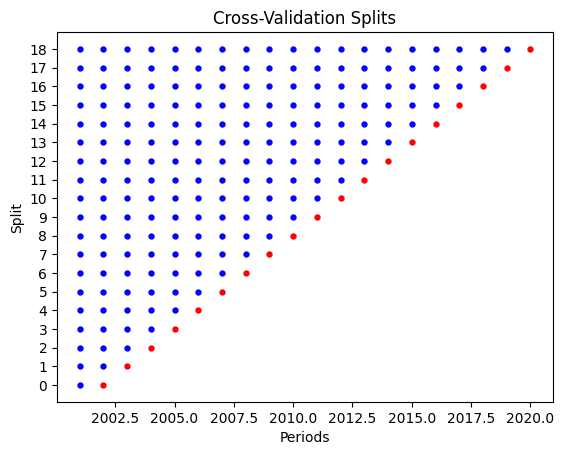

In [4]:
from sklearn.impute import KNNImputer

n_splits = 2020-2001

panel_split = PanelSplit(periods=df.date, n_splits = n_splits, gap=0, test_size=1, plot=True)

df[features], fitted_imputers = panel_split.cross_val_fit_transform(KNNImputer(), df[features], include_test_in_fit=True)

The only observations which are still missing are in 2001. This is because that is the train set for first split.

In [5]:
df[df.isna().any(axis=1)]

,country,date,GDP,Population,Inflation,Trade_Balance
86,Spain,2001,6.277987e+11,40850412.0,NaN,58.01389
214,United Kingdom,2001,1.649827e+12,59119673.0,1.532350,NaN
278,United States,2001,1.058193e+13,284968955.0,2.826171,NaN


We can go ahead and implement imputation for observations that take place in January of 2001

In [6]:
df.loc[df.date == 2001, features] = KNNImputer().fit_transform(df.loc[df.date == 2001, features])

df.isna().sum()

country          0
date             0
GDP              0
Population       0
Inflation        0
Trade_Balance    0
dtype: int64

Now that all observations have all features, we can determine the best set of hyper-parameters to use.

#### Hyper-parameter search

Since PanelSplit is compatible with sklearn, we can use any sklearn hyper-parameter optimizer has takes cv as an argument.

Let's say that our validation period is 2010-2015 and our test period is 2016-2020.


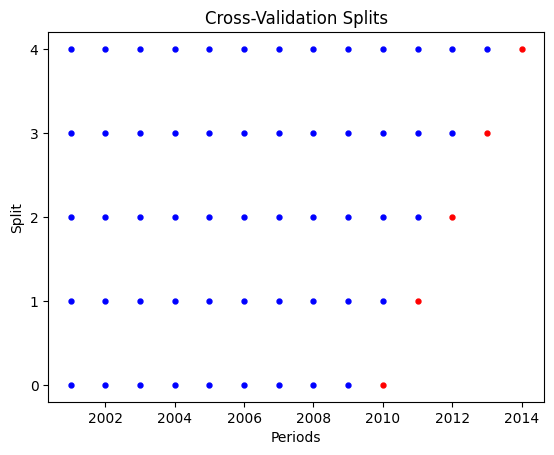

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpen

GridSearch results:


/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017653,0.000961,0.015023,0.000256,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.625316,0.955029,0.955250,0.986807,0.859179,0.876316,0.132612,2
1,0.016592,0.000737,0.014746,0.000477,5,10,"{'max_depth': 5, 'n_estimators': 10}",0.567534,0.968130,0.986139,0.975381,0.893022,0.878041,0.158692,1


In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

validation_df = df.query('date < 2015')

param_grid = {'max_depth': [3, 5], 'n_estimators': [10]}
panel_split = PanelSplit(validation_df.date, n_splits=5, gap=0, test_size=1, plot=True)

grid_search = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), param_grid=param_grid, cv = panel_split, n_jobs=-1, verbose = 1)

grid_search.fit(validation_df[features], validation_df[target])

print('GridSearch results:')
display(pd.DataFrame(grid_search.cv_results_))

Now that we've determined what hyper-parameters to use, let's generate predictions in the test period.

#### `cross_val_fit_predict`
- PanelSplit's cross_val_fit_predict iteratively fits on the train and predicts the test for each fold
- Here are the arguments I use:
    - estimator: estimator object.
    - X: Features.
    - y: Target variable.
    - labels: pandas DataFrame containing labels for the target variable predicted by the model. The predicted target will be a new column added to this DataFrame.
    - prediction_method: The prediction method to use. It can be 'predict', 'predict_proba', or 'predict_log_proba'. Default is 'predict'.
    - y_pred_col: Column name for the predicted values. Default is None, in which case the name will be the name of y.name + 'pred'. If y does not have a name attribute, the name will be 'y_pred'.
    - n_jobs: The number of jobs to run in parallel

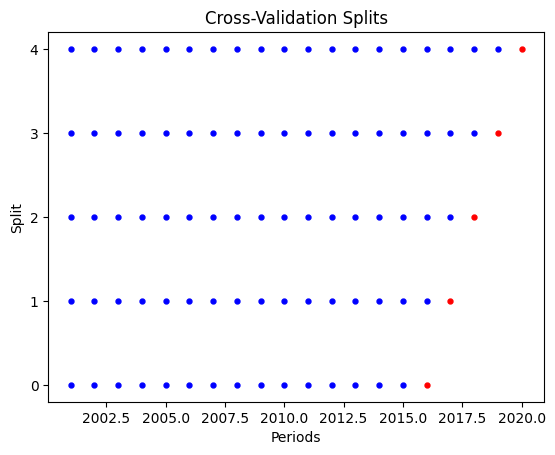

In [8]:
best_params = grid_search.best_params_

panel_split = PanelSplit(df.date, n_splits=5, gap=0, test_size=1, plot=True)
result_df = panel_split.gen_test_labels(df[['country','date', 'GDP']])
result_df['GDP_pred'], models = panel_split.cross_val_fit_predict(RandomForestRegressor(**best_params),  X= df[features], y=df[target])

The output of cross_val_fit_predict is a dataframe of predictions and fitted models. This is what the DataFrame looks like:

In [9]:
result_df

,country,date,GDP,GDP_pred
3,Germany,2020,3.940143e+12,2.555606e+12
4,Germany,2019,3.957208e+12,3.628663e+12
5,Germany,2018,4.052008e+12,5.583282e+12
6,Germany,2017,3.763092e+12,2.390109e+12
7,Germany,2016,3.537784e+12,3.455502e+12
67,Spain,2020,1.289784e+12,1.386435e+12
68,Spain,2019,1.403496e+12,1.531979e+12
69,Spain,2018,1.431643e+12,4.486945e+12
70,Spain,2017,1.321754e+12,1.289593e+12
71,Spain,2016,1.243016e+12,1.361858e+13


Let's assess performance:

In [10]:
from sklearn.metrics import mean_absolute_percentage_error

print('MAPE:', round(mean_absolute_percentage_error(result_df.GDP, result_df.GDP_pred),2))

MAPE: 0.61


## Multiple Snapshots/Updated Values

There are also instances where you might want to keep observations seperate between folds, for example when scaling features. 

In this case, it is recommended that you use cross_val_fit_predict with a Pipeline object.

However, in case you need to manually implement something where observations must be handled differently across folds, PanelSplit's `gen_snapshots` converts a single df to multiple snapshots of that dataframe.

In [11]:
panel_split = PanelSplit(df.date, n_splits = (2020 - 2010), test_size=1)

snapshot_df = panel_split.gen_snapshots(df, period_col = 'date')
print('2 new columns are created: split and snapshot_period:')
display(snapshot_df)
print(f'before gen_snapshot:{df.shape} after gen_snapshot:{snapshot_df.shape}')

2 new columns are created: split and snapshot_period:


,country,date,GDP,Population,Inflation,Trade_Balance,split,snapshot_period
12,Germany,2011,3.824829e+12,80274983.0,2.075173,78.407313,0,2011
13,Germany,2010,3.468154e+12,81776930.0,1.876938,73.862641,0,2011
14,Germany,2009,3.479801e+12,81902307.0,0.312739,66.115269,0,2011
15,Germany,2008,3.808786e+12,82110097.0,2.628380,76.101410,0,2011
16,Germany,2007,3.484057e+12,159262718.8,2.298344,36.712790,0,2011
...,...,...,...,...,...,...,...,...
274,United States,2005,1.303920e+13,197397952.8,3.392747,25.638557,9,2020
275,United States,2004,1.221720e+13,292805298.0,2.677237,24.448057,9,2020
276,United States,2003,1.145645e+13,290107933.0,2.270095,22.627297,9,2020
277,United States,2002,1.092911e+13,287625193.0,1.586032,22.286384,9,2020


before gen_snapshot:(100, 6) after gen_snapshot:(775, 8)


Let's scale our data using `cross_val_fit_transform`. Here each snapshot is scaled separately. We also specify `transform_train=True`, thereby also transforming the training set for each fold.

In [12]:
from sklearn.preprocessing import StandardScaler

panel_split = PanelSplit(periods = snapshot_df.date, snapshots = snapshot_df.snapshot_period, n_splits = (2020 - 2010)) # notice the usage of the snapshots argument
snapshot_df[features], scalers = panel_split.cross_val_fit_transform(StandardScaler(), X= snapshot_df[features], transform_train=True) # transform_train transforms the training set for each fold
display(snapshot_df)

,country,date,GDP,Population,Inflation,Trade_Balance,split,snapshot_period
12,Germany,2011,3.824829e+12,-0.374106,0.028022,2.146437,0,2011
13,Germany,2010,3.468154e+12,-0.356060,-0.244831,1.790462,0,2011
14,Germany,2009,3.479801e+12,-0.354553,-2.397815,1.183626,0,2011
15,Germany,2008,3.808786e+12,-0.352057,0.789463,1.965820,0,2011
16,Germany,2007,3.484057e+12,0.574943,0.335198,-1.119410,0,2011
...,...,...,...,...,...,...,...,...
274,United States,2005,1.303920e+13,0.880059,1.905426,-1.943924,9,2020
275,United States,2004,1.221720e+13,1.924451,1.047622,-2.025887,9,2020
276,United States,2003,1.145645e+13,1.894924,0.559512,-2.151242,9,2020
277,United States,2002,1.092911e+13,1.867746,-0.260592,-2.174713,9,2020


We could then go on to hyper-parameter tune and cross_val_fit_predict our snapshot_df in almost the same way we did before. The only difference, like in the above cell, is that we specify the snapshots argument.